In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime as dt
import seaborn as sns
# import datetime
# import shaply
from shapely.geometry import Point, Polygon
import fiona # fiona needs to be imported before geopandas (otherwise gdp does not work properly)
import geopandas as gpd
import json
from pyproj import CRS
import plotly.graph_objects as go


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# import data

# bike rentals (https://data.london.gov.uk/dataset/number-bicycle-hires)
# metadata = pd.read_excel(Path.cwd().parent/"files"/"tfl-daily-cycle-hires.xlsx")
bike_rentals = pd.read_excel(Path.cwd().parent/"files"/"Assignment3"/"bike_rentals_london.xlsx", sheet_name = 'Data')

# covid (https://data.london.gov.uk/dataset/coronavirus--covid-19--cases)
covid = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/"corona_london.csv")

# weather (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/greater-london/00708_heathrow/qc-version-1)
# metadata od the weather data (https://artefacts.ceda.ac.uk/badc_datadocs/ukmo-midas/WH_Table.html)
li = []

for i in range(2010,2020,1):

    dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)
    li.append(dummy)

weather = pd.concat(li, axis=0, ignore_index=True)

del li, dummy, i



C:\Users\phili\AppData\Local\Temp\ipykernel_3536\1484035747.py:16: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  dummy = pd.read_csv(Path.cwd().parent/"files"/"Assignment3"/f"London_weather_{i}_heathrow.csv", header = 280)


In [3]:
# Preprocessing bike rental data

bike_rentals_month = bike_rentals[['Month', 'Number of Bicycle Hires.1', 'Average Hire Time (mins)']]
# drop NaN rows
bike_rentals_month = bike_rentals_month[bike_rentals_month['Number of Bicycle Hires.1'].notna()]

bike_rentals_year = bike_rentals[['Year', 'Number of Bicycle Hires.2']]
bike_rentals_year = bike_rentals_year.iloc[:bike_rentals_year.Year.isnull().values.argmax()]

bike_rentals = bike_rentals.drop(columns = ['Unnamed: 2', 'Unnamed: 5', 'Unnamed: 8', 'Month.1', 'Month', 'Number of Bicycle Hires.1', \
    'Average Hire Time (mins)', 'Year', 'Number of Bicycle Hires.2'])

bike_rentals.head()

,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [4]:
# Preprocessing weather data

# drop columns with only NaNs
weather = weather.dropna(axis=1, how='all')
# drop rows with only NaNs
weather = weather.dropna(axis=0, how='all')
# drop columns version_num as all values = 1.0, id as all values = 3772, met_domain_name as all values = SYNOP,
# id_type = WMO , 'src_id' = 708
weather = weather.drop(columns = ['version_num', 'id', 'met_domain_name', 'id_type', 'src_id'])
# drop rows where ob_time == 'end data' as all other rows are NaN
weather = weather.drop(weather[weather.ob_time == 'end data'].index)
# drop column wind_speed_unit_id as all values = 4
weather = weather.drop(columns = ['wind_speed_unit_id'])
# drop columns as the method and manner of measurement are not relevant for this analysis
weather = weather.drop(columns = ['rec_st_ind', 'src_opr_type', 'air_temperature_q', 'dewpoint_q', 'wetb_temp_q', 'dewpoint_j', \
    'wetb_temp_j', 'rltv_hum_j', 'midas_stmp_etime', 'meto_stmp_time', 'prst_wx_id'])
# quality control out of the scope of the project -> drop all columns
weather = weather.drop(columns = ['wind_direction_q', 'wind_speed_q', 'prst_wx_id_q', 'cld_ttl_amt_id_q', 'cld_base_ht_q',\
    'visibility_q', 'msl_pressure_q', 'cld_amt_id_1_q', 'cld_base_ht_id_1_q', 'cld_amt_id_2_q', 'cld_base_ht_id_2_q', 'cld_amt_id_3_q',\
    'cld_base_ht_id_3_q', 'stn_pres_q', 'alt_pres_q', 'q10mnt_mxgst_spd_q', 'wmo_hr_sun_dur_q', 'snow_depth_q', 'drv_hr_sun_dur',\
    'drv_hr_sun_dur_q'])
# drop columns not necessary for analysis
weather = weather.drop(columns = ['alt_pres', 'cld_amt_id_1', 'cld_base_ht_id_1', 'cld_amt_id_2', 'cld_base_ht_id_2', 'cld_amt_id_3',\
    'cld_base_ht_id_3', 'q10mnt_mxgst_spd', 'snow_depth', 'cavok_flag'])

# drop rows where air_temperature or wind_speed = NaN
weather = weather[weather['air_temperature'].notna()]
weather = weather[weather['wind_speed'].notna()]
# converting date to datetime
weather['ob_time'] = pd.to_datetime(weather['ob_time'])
# group by day to be able to merge it with the bike rental data
weather = weather.groupby(weather['ob_time'].dt.date).mean().reset_index()
weather['ob_time'] = pd.to_datetime(weather['ob_time'])

## optional
# drop rows where cld_ttl_amt_id, cld_base_ht, visibility, wmo_hr_sun_dur depending on analysis
# weather = weather[weather['cld_ttl_amt_id'].notna()]
# weather = weather[weather['cld_base_ht'].notna()]
# weather = weather[weather['visibility'].notna()]
# weather = weather[weather['wmo_hr_sun_dur'].notna()]


## checks
# NaN check 
weather.isna().sum()

ob_time             0
wind_direction      0
wind_speed          0
cld_ttl_amt_id     43
cld_base_ht        43
visibility          2
msl_pressure        0
air_temperature     0
dewpoint            0
wetb_temp           0
rltv_hum            0
stn_pres            0
wmo_hr_sun_dur     10
dtype: int64

In [5]:
# Preprocessing covid data

# drop all dates without age information
covid = covid[covid.age_band != 'unassigned']
# drop columns area_name, area_code
covid = covid.drop(columns = ['area_name', 'area_code'])
# converting date to datetime
covid['date'] = pd.to_datetime(covid['date'])

In [6]:
# Preprocessing combing bike rentals and weather data by joining on the datetime

bike_rentals_weather = pd.merge(bike_rentals, weather, left_on='Day', right_on='ob_time')


In [7]:
# Preprocessing combing bike rentals and covid data by joining on the datetime

bike_rentals_covid = pd.merge(bike_rentals, covid, left_on='Day', right_on='date')
bike_rentals_weather = bike_rentals_weather.drop(columns=['ob_time'])

# Covid Analysis

In [8]:
bike_rentals_weather

,Day,Number of Bicycle Hires,ob_time,wind_direction,wind_speed,cld_ttl_amt_id,cld_base_ht,visibility,msl_pressure,air_temperature,dewpoint,wetb_temp,rltv_hum,stn_pres,wmo_hr_sun_dur
0,2010-07-30,6897,2010-07-30,267.500000,6.791667,5.500000,123.750000,1883.333333,1014.687500,17.558333,10.479167,13.741667,64.450000,1011.712500,0.130435
1,2010-07-31,5564,2010-07-31,240.000000,9.333333,5.291667,102.083333,2919.583333,1011.554167,19.858333,13.708333,16.358333,69.808333,1008.612500,0.204348
2,2010-08-01,4303,2010-08-01,261.250000,5.916667,7.208333,156.666667,2879.166667,1013.225000,18.795833,11.125000,14.591667,62.675000,1010.266667,0.017391
3,2010-08-02,6642,2010-08-02,247.083333,4.708333,6.500000,173.333333,2470.833333,1016.791667,18.837500,10.483333,14.304167,59.066667,1013.833333,0.091304
4,2010-08-03,7966,2010-08-03,256.666667,6.750000,4.666667,177.083333,1908.333333,1015.687500,17.870833,11.225000,14.225000,66.145833,1012.729167,0.169565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,2019-12-27,11718,2019-12-27,197.500000,4.208333,7.541667,27.083333,1799.583333,1028.804167,7.291667,5.516667,6.500000,88.387500,1025.695833,0.000000
3426,2019-12-28,11414,2019-12-28,167.916667,5.666667,7.958333,25.416667,1532.083333,1036.316667,8.208333,6.550000,7.437500,89.241667,1033.162500,0.000000
3427,2019-12-29,12256,2019-12-29,193.750000,7.125000,6.166667,72.291667,1651.666667,1033.554167,7.404167,5.158333,6.404167,85.612500,1030.408333,0.091304
3428,2019-12-30,16166,2019-12-30,229.166667,5.583333,4.250000,118.181818,781.666667,1029.683333,6.808333,5.695833,6.295833,93.158333,1026.550000,0.152174


In [9]:
bins= [0.0,15.0,30.0,60.0,91.0]
labels = ['Child','Young Adult','Middle-Age Adult','Senior-Citizen']
bike_rentals_covid['AgeGroup'] = pd.cut(bike_rentals_covid['age_lower'], bins=bins, labels=labels, right=False)

In [10]:
bike_rentals_covid = bike_rentals_covid.drop(["age_band"], axis=1)

In [11]:
bike_rentals_covid

,Day,Number of Bicycle Hires,date,cases,rolling_sum,rolling_rate,age_lower,age_higher,population,AgeGroup
0,2020-02-03,28267,2020-02-03,0,0,0.0,0.0,4.0,595799.0,Child
1,2020-02-03,28267,2020-02-03,0,0,0.0,5.0,9.0,606333.0,Child
2,2020-02-03,28267,2020-02-03,0,0,0.0,10.0,14.0,550753.0,Child
3,2020-02-03,28267,2020-02-03,0,0,0.0,15.0,19.0,474456.0,Young Adult
4,2020-02-03,28267,2020-02-03,1,0,0.0,20.0,24.0,556594.0,Young Adult
...,...,...,...,...,...,...,...,...,...,...
13846,2022-01-31,26806,2022-01-31,174,1057,376.9,70.0,74.0,280432.0,Senior-Citizen
13847,2022-01-31,26806,2022-01-31,118,695,353.8,75.0,79.0,196419.0,Senior-Citizen
13848,2022-01-31,26806,2022-01-31,79,447,296.1,80.0,84.0,150980.0,Senior-Citizen
13849,2022-01-31,26806,2022-01-31,43,255,271.8,85.0,89.0,93808.0,Senior-Citizen


<AxesSubplot:title={'center':'cases'}, xlabel='AgeGroup'>

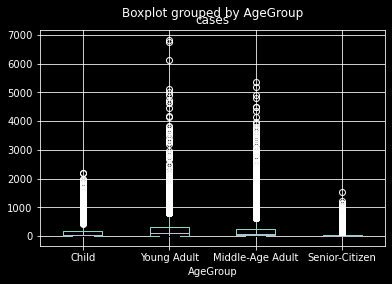

In [12]:
bike_rentals_covid.boxplot('cases','AgeGroup')

In [13]:
bike_rentals_covid['year']=bike_rentals_covid.Day.dt.year
bike_rentals_covid['pickup_date']=bike_rentals_covid.Day.dt.date
bike_rentals_covid['pickup_day']=bike_rentals_covid.Day.dt.day
bike_rentals_covid['pickup_month']=bike_rentals_covid.Day.dt.month

# Extracting the day of the week (dow)
bike_rentals_covid['pickup_dow'] = pd.to_datetime(bike_rentals_covid['Day']).dt.dayofweek

# Type of day column

bike_rentals_covid['pickup_weekend'] = bike_rentals_covid.Day.dt.dayofweek.apply(lambda x: '0' if x <5 else '1')

In [14]:
# Adding the season
bike_rentals_covid['season']=bike_rentals_covid.Day.dt.month.apply(lambda x: 'Winter' if x <=2 else 'Spring' if x<=5 else 'Summer' 
                                             if x<=8 else 'Autumn' if x<=11 else 'Winter')

In [15]:
bike_rentals_covid = bike_rentals_covid.drop(["Day","date"], axis=1)

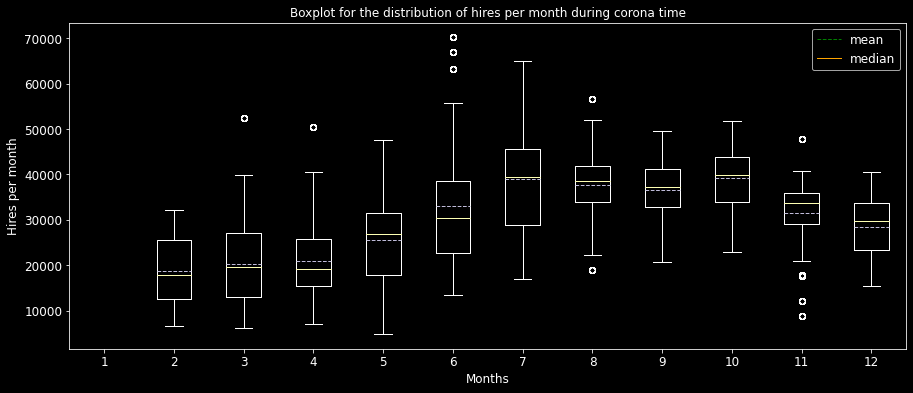

In [16]:
figure = plt.figure(figsize =(15, 6))
bikes_month=[]
for i in range(0,12):
    bikes_month.append(bike_rentals_covid[bike_rentals_covid['pickup_month']==i]['Number of Bicycle Hires'])
    #print(len(bikes[bikes['starttime_hour']==i]['pickups/hr'])) #363-365 because we remove >80 
    # Creating plot
plt.boxplot(bikes_month, showmeans=True, meanline= True)
plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='orange', label='median')
plt.xlabel("Months", fontsize=12)
plt.ylabel("Hires per month", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.title("Boxplot for the distribution of hires per month during corona time")
plt.show()

In [17]:
covid_hires_per_season=bike_rentals_covid.groupby(['pickup_dow','season']).mean()['Number of Bicycle Hires'].reset_index()

In [18]:
covid_hires_per_season

,pickup_dow,season,Number of Bicycle Hires
0,0,Autumn,30097.538462
1,0,Spring,24130.703704
2,0,Summer,33763.518519
3,0,Winter,17984.000000
4,1,Autumn,33323.846154
5,1,Spring,24139.384615
6,1,Summer,37872.703704
7,1,Winter,19339.920000
8,2,Autumn,34065.576923
9,2,Spring,23301.500000


In [19]:
covid_hires_per_dow=bike_rentals_covid.groupby(['pickup_dow','pickup_weekend']).mean()['Number of Bicycle Hires'].reset_index()
covid_hires_per_dow

,pickup_dow,pickup_weekend,Number of Bicycle Hires
0,0,0,26621.714286
1,1,0,28847.163462
2,2,0,28816.971154
3,3,0,28499.365385
4,4,0,29066.423077
5,5,1,33551.682692
6,6,1,29895.961538


Text(0.5, 1.0, 'Hires per season')

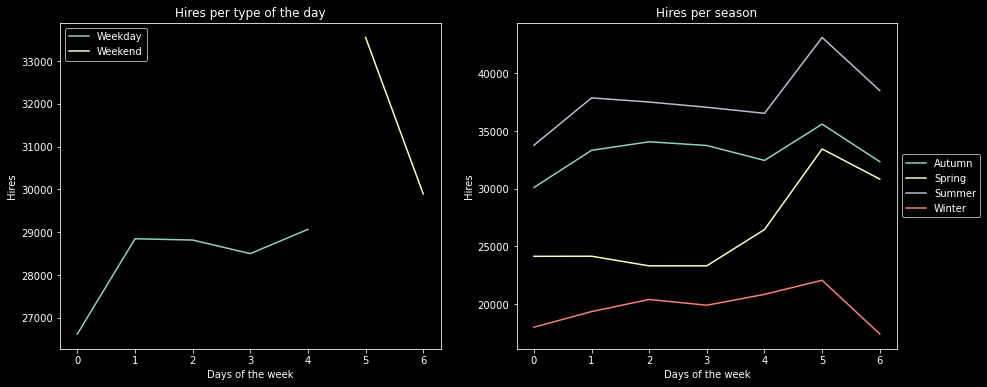

In [20]:
#Plotting pickups based on the type of the day and the season
 
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
#ax = plt.gca()
for weekday in covid_hires_per_dow['pickup_weekend'].unique():
    covid_hires_per_dow[covid_hires_per_dow.pickup_weekend==weekday].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[0],xlabel='Days of the week',ylabel='Hires')
axes[0].legend(['Weekday','Weekend'])
axes[0].set_title('Hires per type of the day')



for season in covid_hires_per_season['season'].unique():
    covid_hires_per_season[covid_hires_per_season.season==season].plot(kind='line',x='pickup_dow',y='Number of Bicycle Hires',ax=axes[1],xlabel='Days of the week',ylabel='Hires')
axes[1].legend(covid_hires_per_season['season'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Hires per season')

In [21]:
covid_cases_per_agegroup=bike_rentals_covid.groupby(['pickup_dow','AgeGroup']).mean()['cases'].reset_index()
covid_cases_per_agegroup

,pickup_dow,AgeGroup,cases
0,0,Child,195.355556
1,0,Young Adult,348.917460
2,0,Middle-Age Adult,300.622222
3,0,Senior-Citizen,51.619048
4,1,Child,177.163462
5,1,Young Adult,363.884615
6,1,Middle-Age Adult,299.600962
7,1,Senior-Citizen,50.391484
8,2,Child,168.230769
9,2,Young Adult,366.371795


Text(0.5, 1.0, 'Covid-19 cases per day of the week per age group')

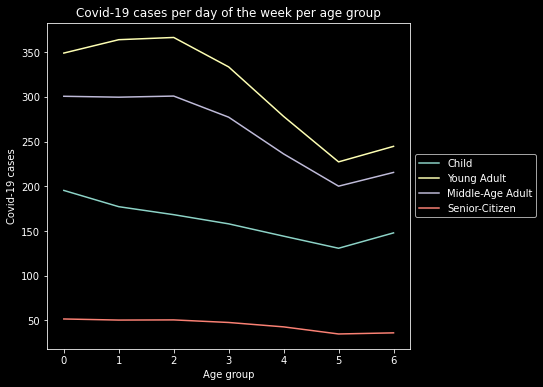

In [22]:
ax = plt.gca()
for agegroup in covid_cases_per_agegroup['AgeGroup'].unique():
    covid_cases_per_agegroup[covid_cases_per_agegroup.AgeGroup==agegroup].plot(kind='line',x='pickup_dow',y='cases',ax=ax,xlabel='Age group',ylabel='Covid-19 cases',figsize=(6.5,6))
plt.legend(covid_cases_per_agegroup['AgeGroup'].unique(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covid-19 cases per day of the week per age group')

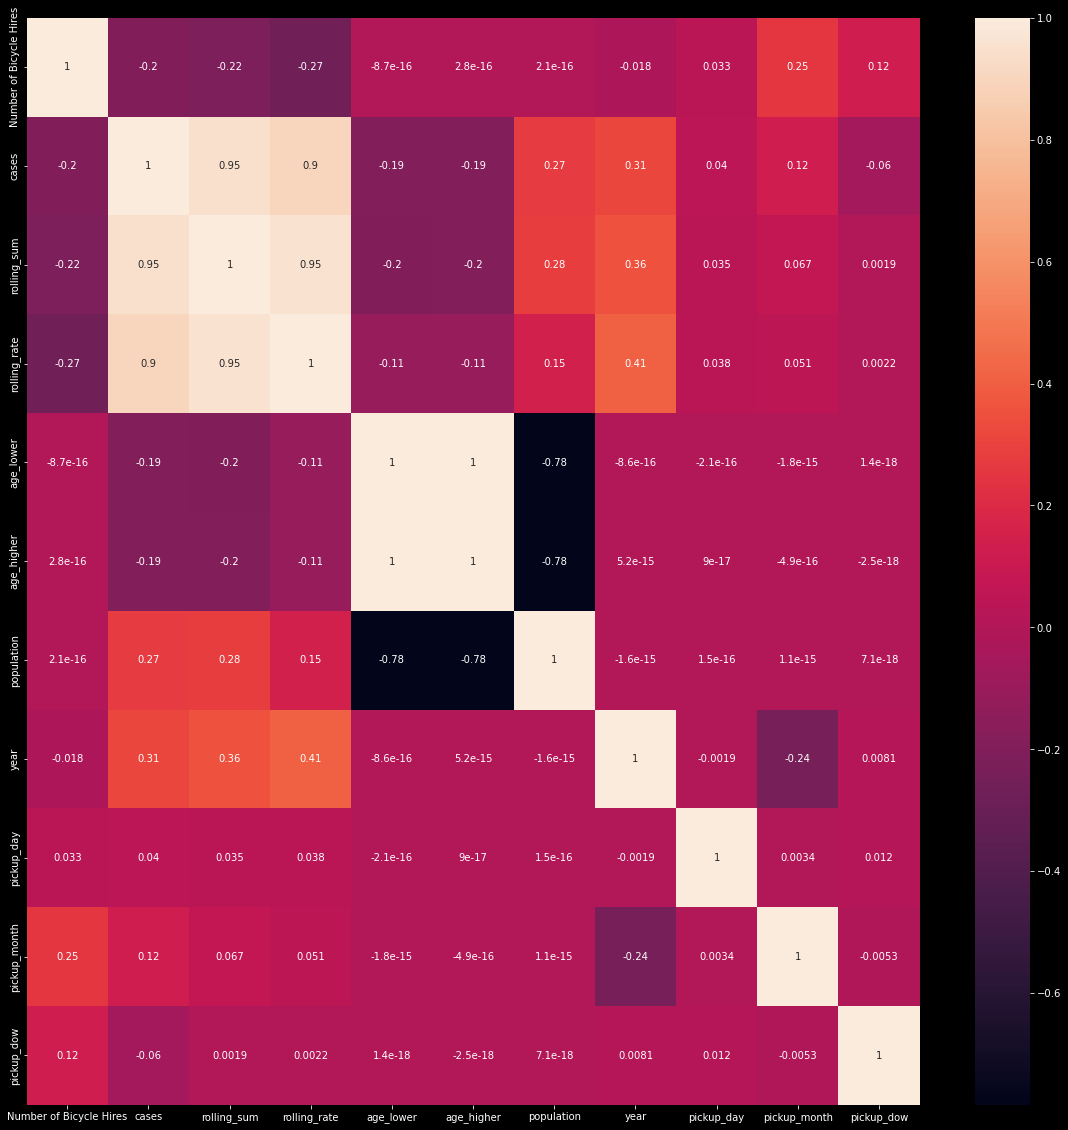

In [23]:
corrMatrix = bike_rentals_covid.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Bicycle Movements

In [24]:
# source: https://cycling.data.tfl.gov.uk/
cycling_load = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"cycling-load.json"))

# insert loop here to download and concate data
tfl = pd.read_csv(cycling_load['entries'][1]['url'])

In [25]:
tfl = pd.DataFrame(tfl)
tfl

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,51053344,60,8158,24/01/2016 00:01,465.0,"Pitfield Street North,Hoxton",24/01/2016 00:00,569,"Pitfield Street Central, Hoxton"
1,51053345,1440,6975,24/01/2016 00:24,201.0,"Dorset Square, Marylebone",24/01/2016 00:00,430,"South Parade, Chelsea"
2,51053346,1860,11995,24/01/2016 00:31,584.0,"Ilchester Gardens, Bayswater",24/01/2016 00:00,335,"Tavistock Street, Covent Garden"
3,51053347,240,8268,24/01/2016 00:04,218.0,"St. Luke's Church, Chelsea",24/01/2016 00:00,589,"Drayton Gardens, West Chelsea"
4,51053348,1680,12776,24/01/2016 00:29,340.0,"Bank of England Museum, Bank",24/01/2016 00:01,238,"Frampton Street, Paddington"
...,...,...,...,...,...,...,...,...,...
292694,51360634,600,10400,07/02/2016 00:07,48.0,"Godliman Street, St. Paul's",06/02/2016 23:57,388,"Southampton Street, Strand"
292695,51360635,240,2320,07/02/2016 00:01,574.0,"Eagle Wharf Road, Hoxton",06/02/2016 23:57,73,"Old Street Station, St. Luke's"
292696,51360636,720,11143,07/02/2016 00:09,535.0,"Gloucester Avenue, Camden Town",06/02/2016 23:57,109,"Soho Square , Soho"
292697,51360637,900,6848,07/02/2016 00:14,732.0,"Duke Street Hill, London Bridge",06/02/2016 23:59,443,"Philpot Street, Whitechapel"


In [26]:
# source: https://api-portal.tfl.gov.uk/api-details#api=BikePoint&operation=BikePoint_GetAll
bikepoint = json.load(open(Path.cwd().parent/"files"/"Assignment3"/"bikepoint.json"))

In [27]:
bikepoint = pd.DataFrame(bikepoint)
bikepoint = bikepoint.drop(['$type', 'url', 'placeType', 'additionalProperties', 'children', 'childrenUrls'], axis='columns')
bikepoint

,id,commonName,lat,lon
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970
1,BikePoints_2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,BikePoints_3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,BikePoints_4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,BikePoints_5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...,...
786,BikePoints_692,"Cadogan Close, Victoria Park",51.542118,-0.028941
787,BikePoints_693,"Felsham Road, Putney",51.464786,-0.215618
788,BikePoints_694,"Putney Rail Station, Putney",51.460717,-0.216526
789,BikePoints_695,"Islington Green, Angel",51.536384,-0.102757


In [28]:
list_id = list(range(1,len(bikepoint)+1))
bikepoint['id'] = list_id
bikepoint

,id,commonName,lat,lon
0,1,"River Street , Clerkenwell",51.529163,-0.109970
1,2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...,...
786,787,"Cadogan Close, Victoria Park",51.542118,-0.028941
787,788,"Felsham Road, Putney",51.464786,-0.215618
788,789,"Putney Rail Station, Putney",51.460717,-0.216526
789,790,"Islington Green, Angel",51.536384,-0.102757


In [29]:
data = pd.merge(tfl, bikepoint, left_on="StartStation Id", right_on="id")
data = data.rename(columns={'id': 'id_start', 'lon' : 'lon_start', 'lat' : 'lat_start'})
data = pd.merge(data, bikepoint, left_on="EndStation Id", right_on="id")
data = data.rename(columns={'id': 'id_end', 'lon' : 'lon_end', 'lat' : 'lat_end'})
#data = data.dropna()
data.isnull().sum()

Rental Id            0
Duration             0
Bike Id              0
End Date             0
EndStation Id        0
EndStation Name      0
Start Date           0
StartStation Id      0
StartStation Name    0
id_start             0
commonName_x         0
lat_start            0
lon_start            0
id_end               0
commonName_y         0
lat_end              0
lon_end              0
dtype: int64

In [30]:
data.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,id_start,commonName_x,lat_start,lon_start,id_end,commonName_y,lat_end,lon_end
0,51053344,60,8158,24/01/2016 00:01,465.0,"Pitfield Street North,Hoxton",24/01/2016 00:00,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
1,51058086,1500,472,24/01/2016 12:49,465.0,"Pitfield Street North,Hoxton",24/01/2016 12:24,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
2,51209656,180,10662,31/01/2016 01:29,465.0,"Pitfield Street North,Hoxton",31/01/2016 01:26,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
3,51218482,120,11115,31/01/2016 18:28,465.0,"Pitfield Street North,Hoxton",31/01/2016 18:26,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164
4,51218648,60,5223,31/01/2016 18:41,465.0,"Pitfield Street North,Hoxton",31/01/2016 18:40,569,"Pitfield Street Central, Hoxton",569,"Arlington Road, Camden Town",51.539957,-0.145246,465,"Porchester Place, Paddington",51.514746,-0.165164


In [103]:
# Import street map (source: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)
street_map = gpd.read_file(Path.cwd().parent/"files"/"Assignment3"/"London-wards-2014_ESRI"/'London_Ward_CityMerged.shp')

# Creating new dataframe for storing relevant data for geo-visualization
data_location=pd.DataFrame()

In [32]:
#creating new column which contains combined latitude and longitude
data["location"]=list(zip(data["lat_start"], data["lon_start"]))

data_location["location"]=data["location"]
# Storing only unique location
data_location=data_location.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
data_location=data_location.dropna()
# Caluclating how much each location is "visited" to get consumption
data_location["consumption"]=list(data["location"].value_counts())

In [33]:
# Making empty lists to store longitude and latitude to be used for geopandas library instance .points_from_xy
longitude=[]
latitude=[]
for x, y in data_location["location"]:
    longitude.append(x)
    latitude.append(y)

# Designate coordinate system
crs = CRS(init="epsg:4544")
geometry=gpd.points_from_xy(latitude,longitude)
# Create GeoPandas dataframe
geometry=geometry
geo_data = gpd.GeoDataFrame(data_location,
 crs = crs,
 geometry = geometry)

C:\Users\phili\anaconda3\envs\socialdata2022_py_3.9\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


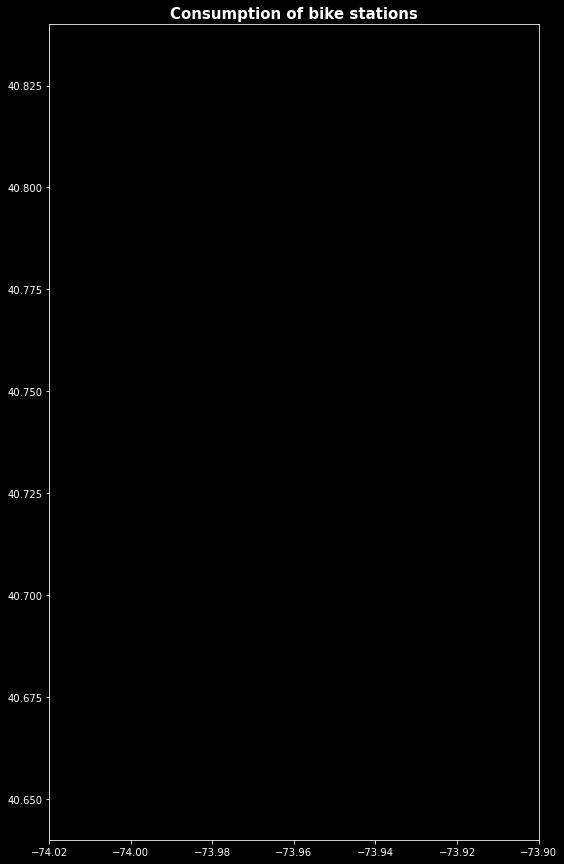

In [54]:
# Create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
# Add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')
# Add geodataframe to axes
geo_data.plot(column='consumption',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title("Consumption of bike stations", fontsize=15,fontweight='bold')
# Set latitiude and longitude boundaries for map display
plt.xlim(-74.02,-73.9)
plt.ylim(40.64,40.84)
plt.show()

# Weather analysis

In [35]:
# we have data: cycling_load (bunch of stuff), weather, bike_rentals

plan: 
- check weather metadata (done)
- prune the bike rental data to exclude covid, (to match weather data time wise). (done)
- see what patterns can be seen if weather data is plotted against bike rentals.
    - plot things individually (done)
    - try to find correlation (the heatmap style) (done)
    - bin for each variable
- check classes for other tools / plots to make
- go through the cycling_load, what data it has, and what can i show with it.

In [37]:
#match times of the weather and bike rental data: bike rental starts from 2010 07 30 and finishes at 2022 01 31.
#while the weather data starts at: 2010 01 01 and finishes at 2019 12 31
#so we start with cutting the first half year of the weather data.
weatherCut = weather.loc[weather['ob_time'] >= dt.strptime("2010 7 30", "%Y %m %d" )]
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentals.loc[bike_rentals['Day'] < dt.strptime("2020 1 1", "%Y %m %d" )]
#it appears to be that there is more bike rental data than weather by 12.
print(len(weatherCut))
type(bike_rentalsCut)

3430


pandas.core.frame.DataFrame

In [38]:
#we find any piece of data that does not exist in the other dataframe. 
#we find missing data in weather data but not the other way around
missingTimes = []
for time in bike_rentalsCut['Day']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(weatherCut['ob_time'].isin(listLikeObject).any().any()):
        print('value does not exist in weatherCut', time)
        missingTimes.append(time)
        
for time in weatherCut['ob_time']:
    listLikeObject = []
    listLikeObject.append(time)
    if not(bike_rentalsCut['Day'].isin(listLikeObject).any().any()):
        print('value does not exist in bike_rentalsCut', time)

value does not exist in weatherCut 2013-05-08 00:00:00
value does not exist in weatherCut 2013-05-10 00:00:00
value does not exist in weatherCut 2013-05-11 00:00:00
value does not exist in weatherCut 2013-05-12 00:00:00
value does not exist in weatherCut 2013-05-13 00:00:00
value does not exist in weatherCut 2014-06-10 00:00:00
value does not exist in weatherCut 2014-06-11 00:00:00
value does not exist in weatherCut 2014-06-12 00:00:00
value does not exist in weatherCut 2014-06-13 00:00:00
value does not exist in weatherCut 2014-06-14 00:00:00
value does not exist in weatherCut 2014-06-15 00:00:00
value does not exist in weatherCut 2019-05-21 00:00:00


In [39]:
#then we remove the missing days from the bike rental data
dropindices = []
for missingTime in missingTimes:
    dropindices.append(bike_rentalsCut[bike_rentalsCut['Day'] == missingTime].index[0])

bike_rentalsCut = bike_rentalsCut.drop(index = dropindices)
weatherCut = weatherCut.reset_index()
bike_rentalsCut = bike_rentalsCut.reset_index()
#now we see that the dates are synced up. 
print(len(weatherCut))
print(len(bike_rentalsCut))

3430
3430


In [40]:
#rename columns to have the same name
weatherCut.rename(columns = {'ob_time':'Day'}, inplace = True)

#merge the dataframes
weatherJoined = pd.merge(weatherCut, bike_rentalsCut, on = "Day", how = "inner")

#drop not needed columns
weatherJoined.drop('index_x',axis=1, inplace = True)
weatherJoined.drop('level_0',axis=1, inplace = True)
weatherJoined.drop('index_y',axis=1, inplace = True)

#drop NAN values
weatherJoined.dropna(inplace=True)

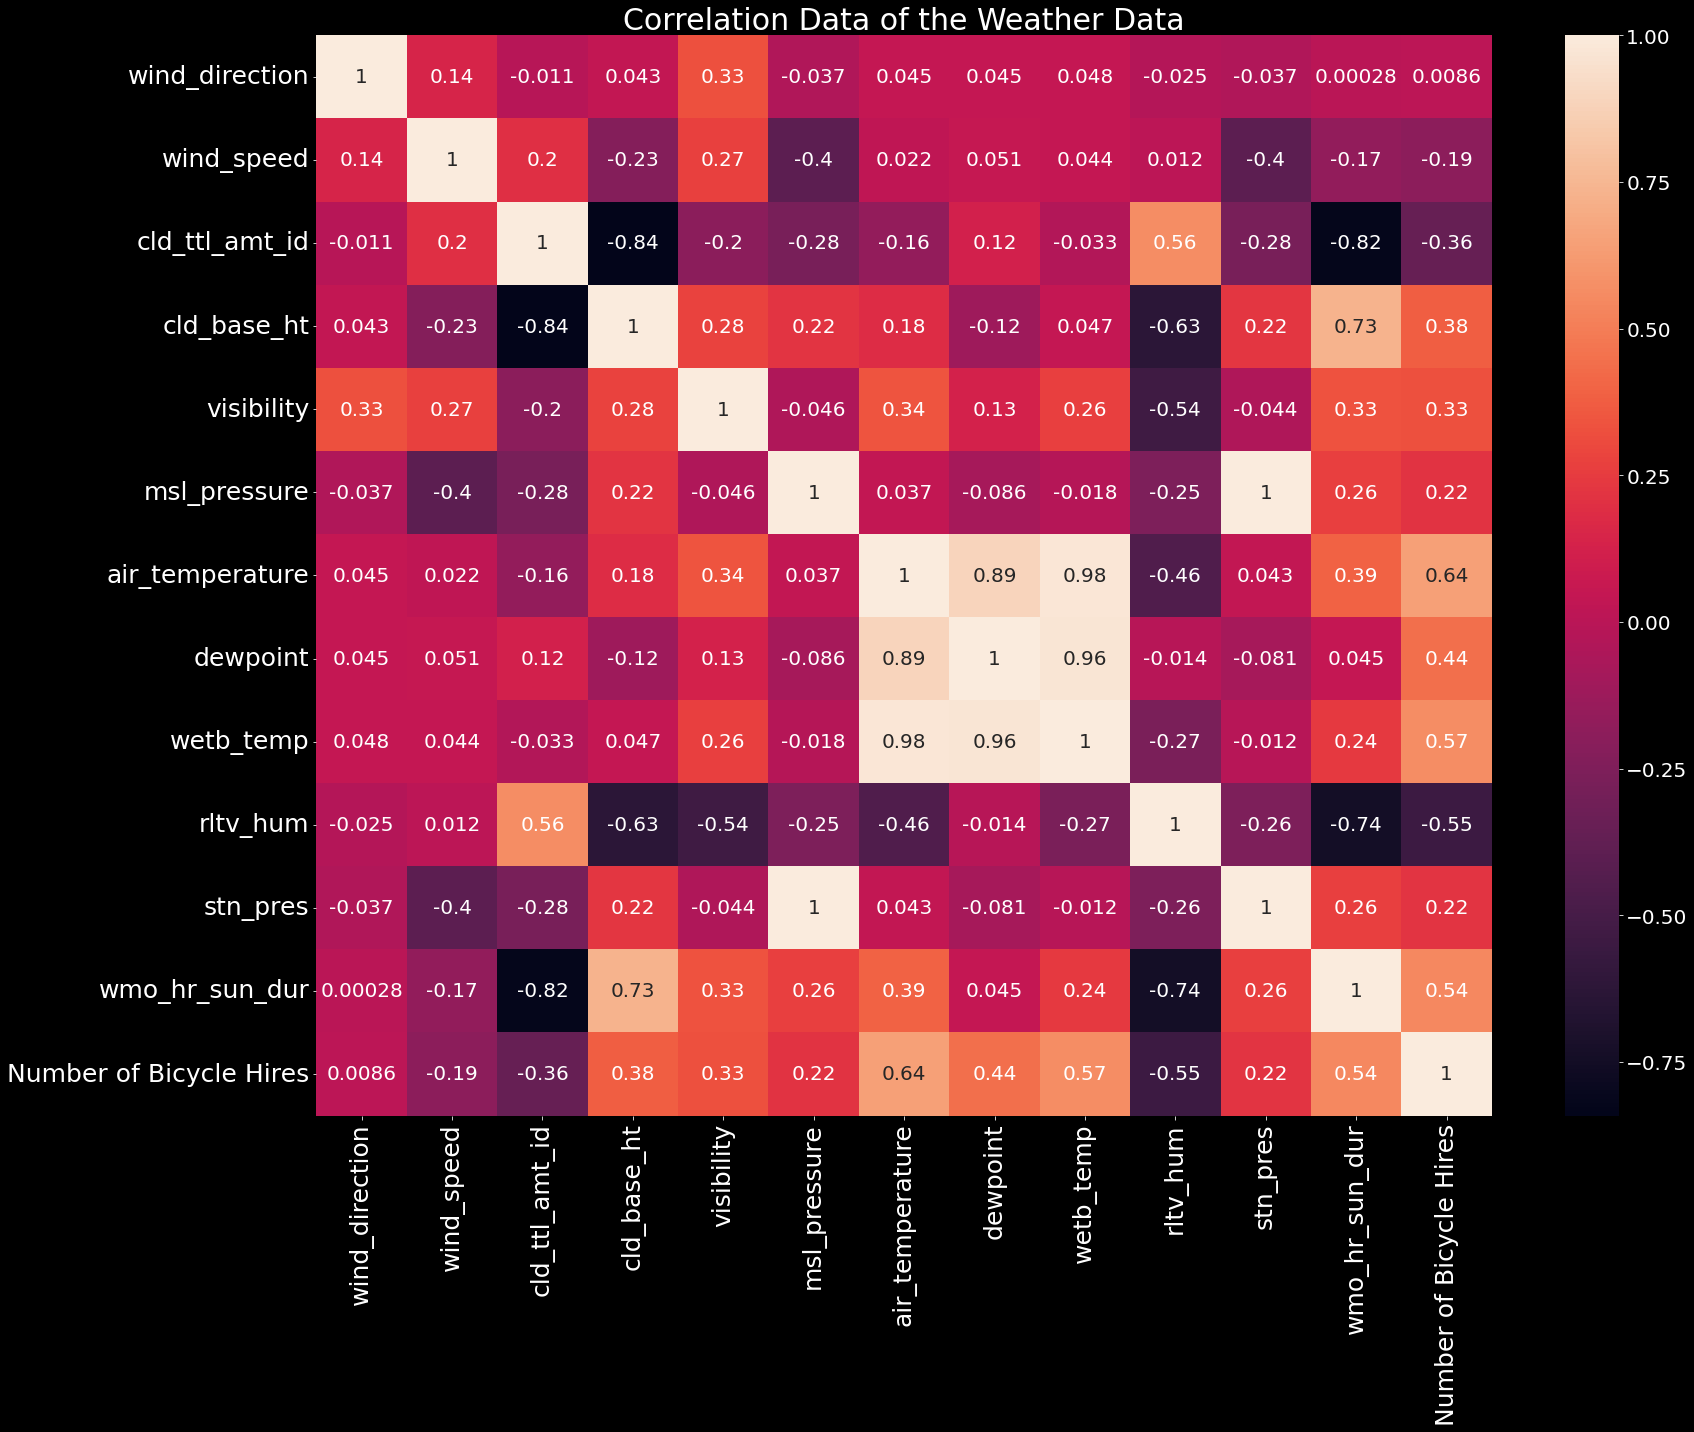

In [156]:
corrMatrix = weatherJoined.corr()
plt.figure(figsize=(25, 20))
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 20})
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.title('Correlation Data of the Weather Data', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

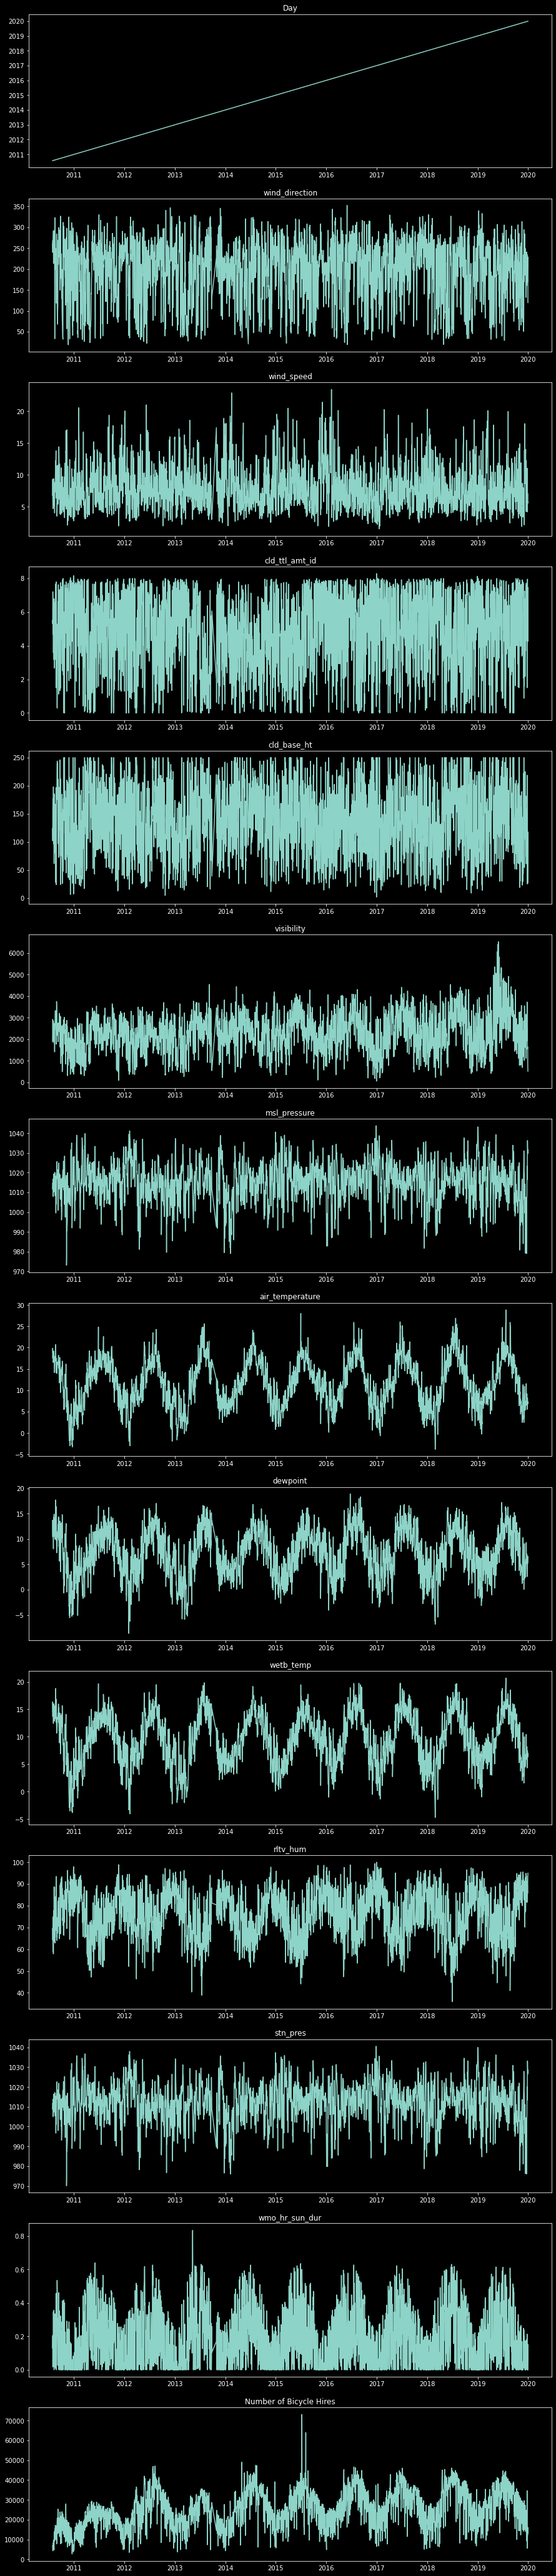

In [42]:
#plot everything compared to day, to get a feel how the variables change over time. 
plt.figure(figsize=(15, 75))
counter = 1
for col in weatherJoined.columns:
    ax = plt.subplot(len(weatherJoined.columns), 1, counter)
    ax.set_title(col)
    plt.plot(weatherJoined['Day'], weatherJoined[col])
    counter = counter + 1

In [43]:
# now we will try to bin for each variable, then make boxplots to see how it affects the rental numbers.
counter = 1

weatherBinned = pd.DataFrame(weatherJoined['Number of Bicycle Hires'])
for col in weatherJoined.columns:
    binColTitle = col + ' binned'
    bins = [weatherJoined[col].min(),
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.2,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.4,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.6,
            weatherJoined[col].min() + (weatherJoined[col].max() - weatherJoined[col].min()) * 0.8, 
            weatherJoined[col].max()]
    labels = ['Lowest', 'Low', 'Medium', 'High', 'Highest']
    weatherBinned[binColTitle] = pd.cut(weatherJoined[col], bins, include_lowest = True, labels = labels)
    counter = counter + 1

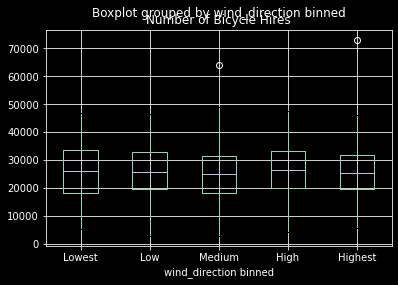

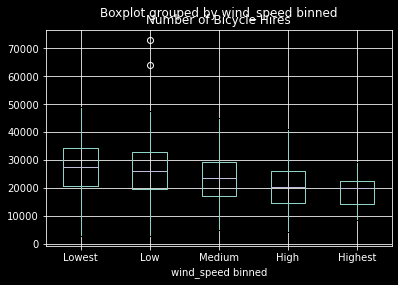

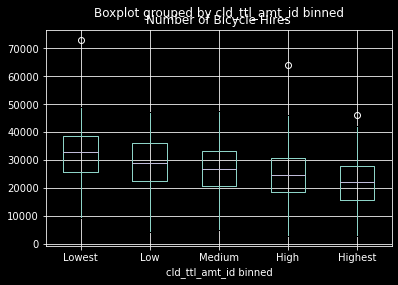

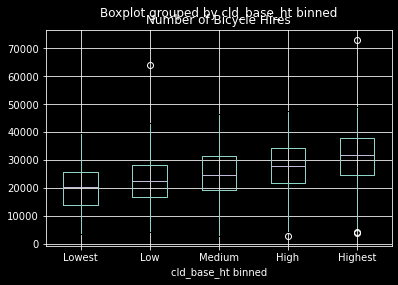

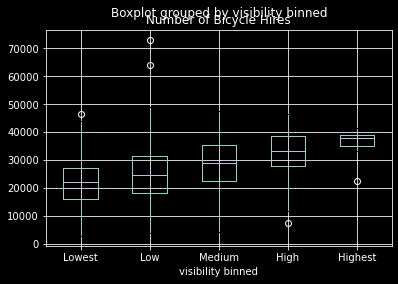

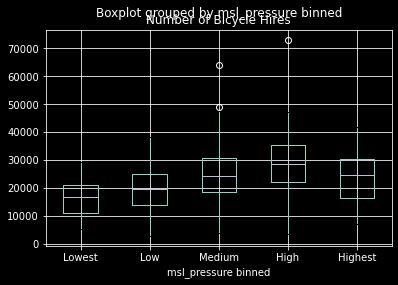

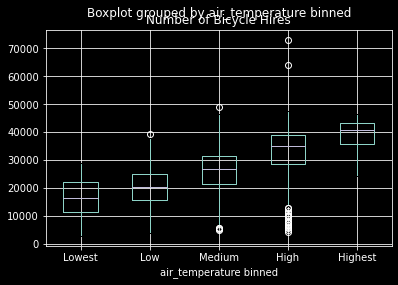

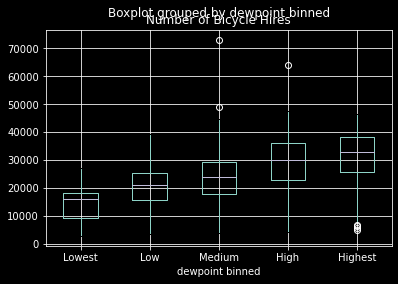

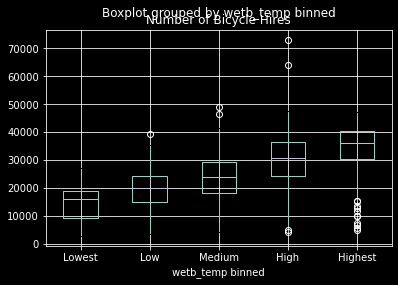

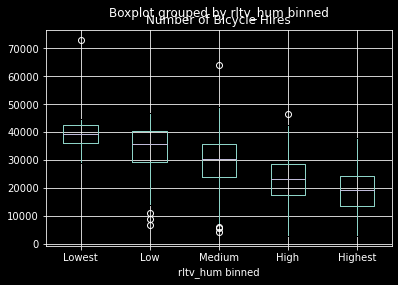

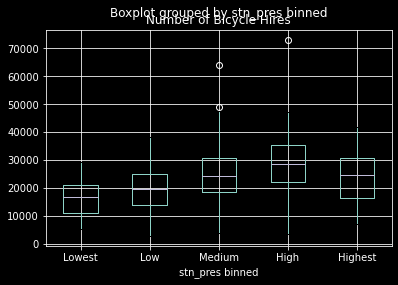

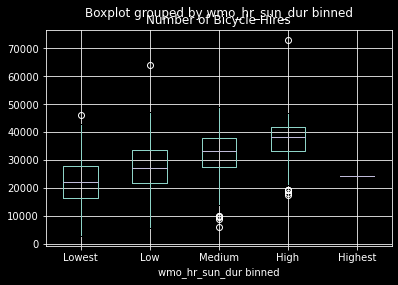

In [44]:
# generate boxplots
for col in weatherBinned.columns:
    if(col == 'Number of Bicycle Hires' or col == 'Day binned' or col == 'Number of Bicycle Hires binned'):
        continue
    weatherBinned.boxplot('Number of Bicycle Hires', col)


# Machine Learning Model to predict Bike-Sharing Demand

In [ ]:
# inspiration:
# notebook: https://github.com/shayanalibhatti/Predicting_Bike_Share_Demand_with_LSTM/blob/master/Bike_Share_Prediction_Code.ipynb
# articel: https://medium.com/analytics-vidhya/capital-bike-share-demand-prediction-using-machine-learning-3c6c2c958e82

In [129]:
bike_rentals.head()

,Day,Number of Bicycle Hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [128]:
bike_rentals.describe()

,Number of Bicycle Hires
count,4204.000000
mean,26320.135347
std,9693.146364
min,2764.000000
25%,19271.000000
50%,26145.500000
75%,33371.000000
max,73094.000000


<AxesSubplot:>

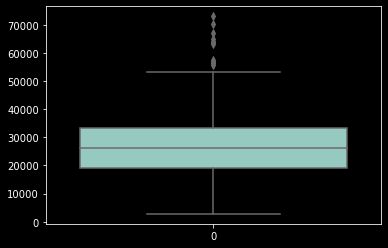

In [131]:
sns.boxplot(data = bike_rentals['Number of Bicycle Hires'])

In [266]:
pd.date_range(start = np.min(bike_rentals_weather.index), end = np.max(bike_rentals_weather.index) ).difference(bike_rentals_weather.index)
# missing a few dates -> 12


DatetimeIndex(['2013-05-08', '2013-05-10', '2013-05-11', '2013-05-12', '2013-05-13', '2014-06-10', '2014-06-11', '2014-06-12', '2014-06-13', '2014-06-14', '2014-06-15', '2019-05-21'], dtype='datetime64[ns]', freq=None)

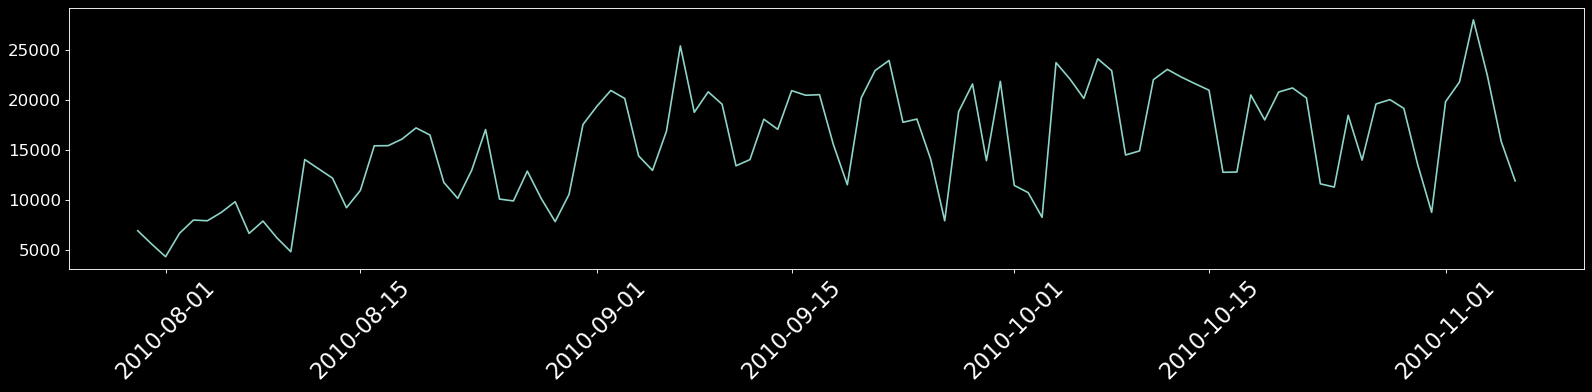

In [160]:
bike_rentals.head()

plt.figure(figsize=(20, 5), dpi=80)
plt.plot(bike_rentals['Day'][:100], bike_rentals['Number of Bicycle Hires'][:100])
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [137]:
from sklearn.model_selection import train_test_split



In [196]:
bike_rentals_weather.head()

# drop ob_time, 

# correlation of features:
# cld_base_ht, cld_ttl_amt_id -> -0.84
# dewpoint, air_temperature -> 0.89
# wetb_temp, air_temperature -> 0.98
# wetb_temp, dewpoint -> 0.96

# correltaion of features with the target (Number of Bicycle Hires)
# air_temperature -> 0.64
# weth_temp -> 0.57
# rltv_hum -> -0.55
# wmo_hr_sun_dur -> 0.54


# pairwise correlation -> choose the one with higher correlation with the target

# analysing only correlation is fine as no categorical variables

###
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

# def correlation(dataset, threshold):
#     col_corr = set()  # Set of all the names of correlated columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
#                 colname = corr_matrix.columns[i]  # getting the name of column
#                 col_corr.add(colname)
#     return col_corr

# correlation(bike_rentals_weather, 0.5)

,Day,Number of Bicycle Hires,ob_time,wind_direction,wind_speed,cld_ttl_amt_id,cld_base_ht,visibility,msl_pressure,air_temperature,dewpoint,wetb_temp,rltv_hum,stn_pres,wmo_hr_sun_dur
0,2010-07-30,6897,2010-07-30,267.500000,6.791667,5.500000,123.750000,1883.333333,1014.687500,17.558333,10.479167,13.741667,64.450000,1011.712500,0.130435
1,2010-07-31,5564,2010-07-31,240.000000,9.333333,5.291667,102.083333,2919.583333,1011.554167,19.858333,13.708333,16.358333,69.808333,1008.612500,0.204348
2,2010-08-01,4303,2010-08-01,261.250000,5.916667,7.208333,156.666667,2879.166667,1013.225000,18.795833,11.125000,14.591667,62.675000,1010.266667,0.017391
3,2010-08-02,6642,2010-08-02,247.083333,4.708333,6.500000,173.333333,2470.833333,1016.791667,18.837500,10.483333,14.304167,59.066667,1013.833333,0.091304
4,2010-08-03,7966,2010-08-03,256.666667,6.750000,4.666667,177.083333,1908.333333,1015.687500,17.870833,11.225000,14.225000,66.145833,1012.729167,0.169565


In [211]:
# LSTM Model
# imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.autograd import Variable
from torch import nn

# source
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

C:\Users\phili\anaconda3\envs\socialdata2022_py_3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [282]:
# Preprocessing
bike_rentals_weather = bike_rentals_weather.set_index('Day')
bike_rentals_weather = bike_rentals_weather.dropna()
X, y = bike_rentals_weather.drop(columns=['Number of Bicycle Hires']), bike_rentals_weather['Number of Bicycle Hires'].values
X.shape, y.shape

((3376, 12), (3376,))

In [230]:
# Feature Scaling
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [268]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 10, 1) # based on n_steps_in predict n_steps_out
print(X_ss.shape, y_mm.shape)

(3367, 10, 12) (3367, 1)


In [269]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (3217, 10, 12) (3217, 1)
Testing Shape: (150, 10, 12) (150, 1)


In [270]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [271]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 10, # n_steps_in
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 10, # n_steps_in
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([3217, 10, 12]) torch.Size([3217, 1])
Testing Shape: torch.Size([150, 10, 12]) torch.Size([150, 1])


In [272]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [275]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [260]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 12 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes # n_steps_out

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [276]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.01138, test loss: 0.01634
Epoch: 100, train loss: 0.01111, test loss: 0.01404
Epoch: 200, train loss: 0.01095, test loss: 0.01422
Epoch: 300, train loss: 0.01086, test loss: 0.01422
Epoch: 400, train loss: 0.01077, test loss: 0.01432
Epoch: 500, train loss: 0.01071, test loss: 0.01430
Epoch: 600, train loss: 0.01066, test loss: 0.01425
Epoch: 700, train loss: 0.01062, test loss: 0.01439
Epoch: 800, train loss: 0.01058, test loss: 0.01434
Epoch: 900, train loss: 0.01054, test loss: 0.01437


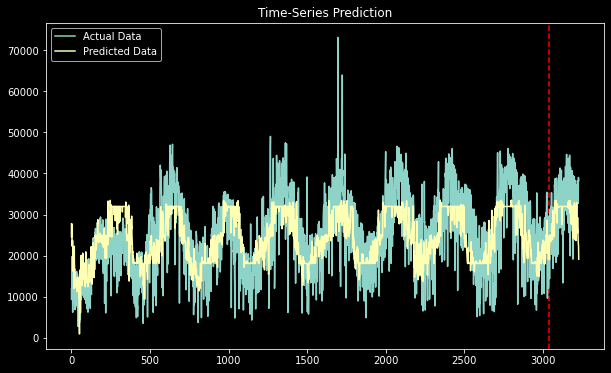

In [277]:
df_X_ss = ss.transform(bike_rentals_weather.drop(columns=['Number of Bicycle Hires'])) # old transformers
df_y_mm = mm.transform(bike_rentals_weather['Number of Bicycle Hires'].values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

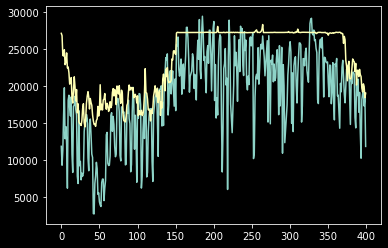

In [248]:
plt.plot(true[:400], label='Actual Data') # actual plot
plt.plot(preds[:400], label='Predicted Data') # predicted plot

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

scaler = scaler.fit(X_train)

train_data = scaler.transform(X_train)

test_data = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2363, 12), (1013, 12), (2363,), (1013,))

In [319]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [318]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2357, 5, 12]),
 torch.Size([2357, 12]),
 torch.Size([1007, 5, 12]),
 torch.Size([1007, 12]))

In [298]:
class BikeSharingDemandPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(BikeSharingDemandPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [299]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [302]:
model = BikeSharingDemandPredictor(
  n_features=12, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 7439.26953125 test loss: 3176.63232421875
Epoch 10 train loss: 1668.3927001953125 test loss: 724.4847412109375
Epoch 20 train loss: 1570.10302734375 test loss: 680.4488525390625
Epoch 30 train loss: 1537.68017578125 test loss: 664.7028198242188
Epoch 40 train loss: 1526.28466796875 test loss: 659.7531127929688
Epoch 50 train loss: 1522.155029296875 test loss: 659.3741455078125


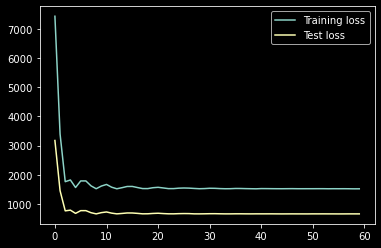

In [304]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")

plt.legend();

In [312]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float() # seg_length needs to be 60??

RuntimeError: shape '[1, 5, 1]' is invalid for input of size 60

In [311]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

ValueError: operands could not be broadcast together with shapes (1,12084) (12,) (1,12084) 